In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import Counter



import copy
from facenet_pytorch import InceptionResnetV1

In [3]:
plt.ion()   # interactive mode

data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(299),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = 'data'
image_datasets = datasets.ImageFolder(data_dir,data_transforms)

dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=4, shuffle=True, num_workers=4)
dataset_sizes = len(image_datasets) 

class_names = image_datasets.classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using " + str(device))


Using cuda


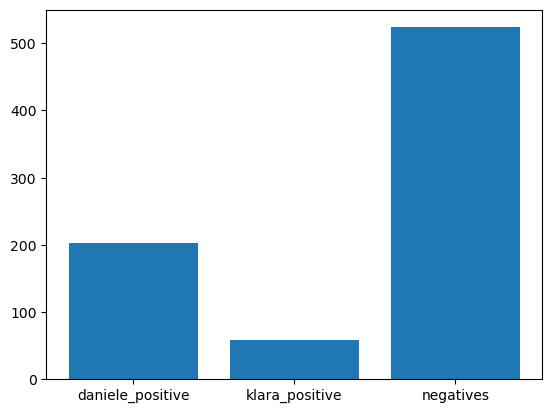

In [4]:
data = dict(Counter(image_datasets.targets))

names = list(image_datasets.classes)
values = list(data.values())

plt.bar(range(len(data)), values, tick_label=names)
plt.show()

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(5)  # pause a bit so that plots are updated

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model.train()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_accuracy = 0.0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            scheduler.step()

            loss = loss.item() # detach gradient

            preds = torch.argmax(outputs, dim=1) 
            corrects = torch.sum(preds == labels)

            running_accuracy += corrects
            running_loss += loss

        running_loss /= dataset_sizes
        running_accuracy /= dataset_sizes
        print(f"loss = {running_loss} accuracy = {running_accuracy}")

        if running_accuracy > best_acc:
            best_acc = running_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [10]:
model_ft = InceptionResnetV1(pretrained='vggface2', device=device, classify= True, num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=40)

model_path = "trained_model.pt"
print("Saving model "+model_path)
torch.save(model_ft.state_dict(), model_path)

Epoch 0/39
----------
loss = 0.4688713989590537 accuracy = 0.5356164574623108

Epoch 1/39
----------
loss = 0.4946634607823336 accuracy = 0.5479452013969421

Epoch 2/39
----------
loss = 0.4315396925051735 accuracy = 0.5794520974159241

Epoch 3/39
----------


KeyboardInterrupt: 